# Explore here

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

In [4]:
# Read.
df = pd.read_csv("../data/raw/diabetes.csv")
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [5]:
# Informacion sobre columnas y valores nulos
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [6]:
# Descripción.(aqui buscamos media y desviacion estandar)
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


.describe() muestra que hay columnas que tienen un mínimo igual a cero. Entonces, es de interés analizarlas antes de realizar el modelo.

In [7]:
# Valores faltantes por columna
df.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

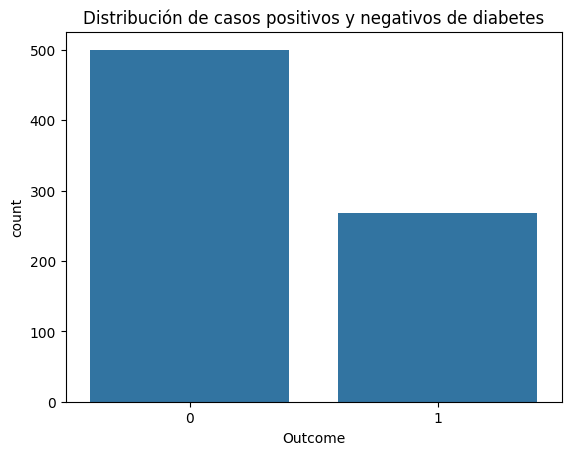

In [8]:
# Gráfico de la distribución de pacientes con y sindiabetes.
sns.countplot(x=df["Outcome"])
plt.title("Distribución de casos positivos y negativos de diabetes")
plt.show()

Nos permite entender si el dataset está balanceado o si hay un sesgo en la cantidad de positivos y negativos.

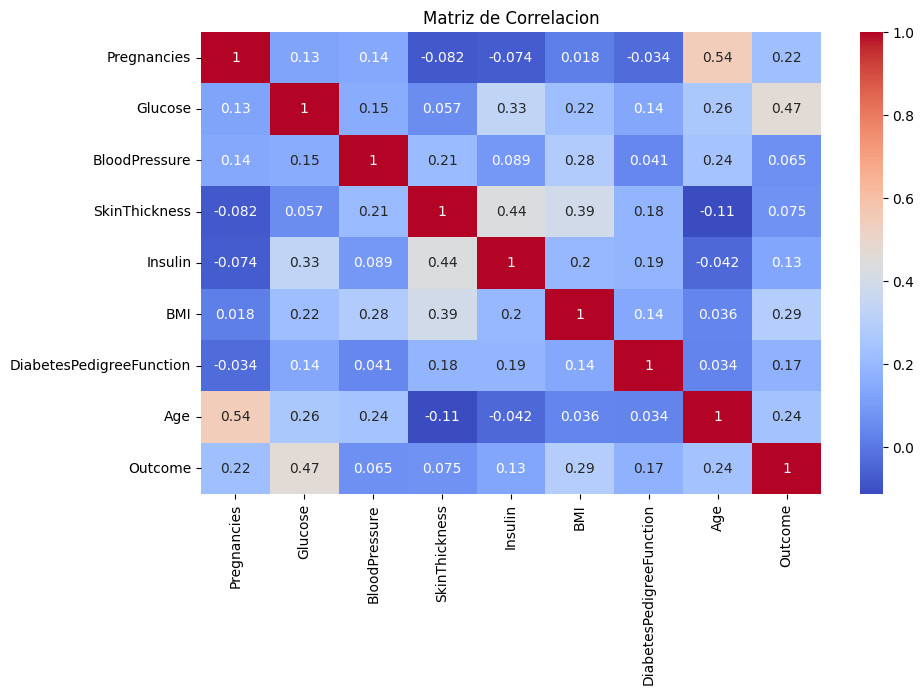

In [9]:
#Correlaciones
plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')# sirve para ver la correlacion entre variables.
plt.title("Matriz de Correlacion")
plt.show()

Si la correlacion es alta, la variable es importante y se considrara en el modelo, enn cambio si es baja hay que evaluarla y decidir si eliminarla.

In [10]:
# Análisis de columnas con mínimo igual a 0
zero_min_cols = df.describe().loc['min'] == 0
zero_min_features = zero_min_cols[zero_min_cols].index.tolist()
print("Columnas con mínimo igual a 0:", zero_min_features)

Columnas con mínimo igual a 0: ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'Outcome']


Identificamos las columnas con valores minimos igual a cero.

In [11]:
# Calcular el porcentaje de ceros en cada columna
zero_percentage = (df[zero_min_features] == 0).sum() / len(df) * 100
print("Porcentaje de valores cero por columna:\n", zero_percentage)

Porcentaje de valores cero por columna:
 Pregnancies      14.453125
Glucose           0.651042
BloodPressure     4.557292
SkinThickness    29.557292
Insulin          48.697917
BMI               1.432292
Outcome          65.104167
dtype: float64


Si una caracteristica tiene un alto porcentaje de valores cero, podriamos eliminarla, despues podemos reemplazar los ceros con la mediana o media, si el porcentaje es moderado.

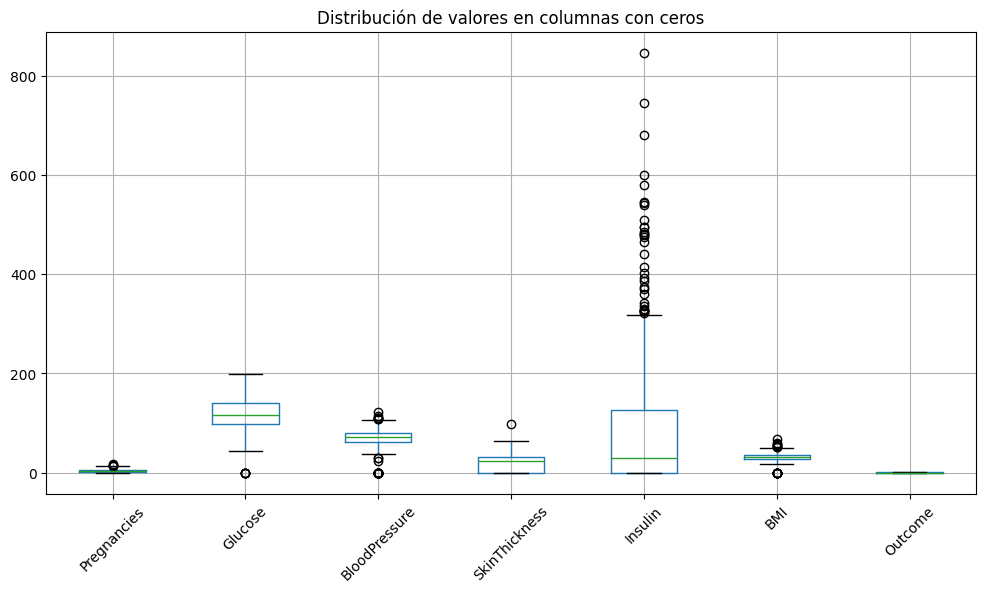

In [12]:
# Visualizar distribución con boxplots
plt.figure(figsize=(12, 6))
df[zero_min_features].boxplot()
plt.xticks(rotation=45)
plt.title("Distribución de valores en columnas con ceros")
plt.show()

Vemos que hay muhcas anomalias y decido hacer una imputacion.

In [13]:
# Reemplazo de valores cero con la mediana
df_imputed = df.copy()
for col in zero_min_features:
    df_imputed[col] = df_imputed[col].replace(0, df_imputed[col].median())
# Antes de la imputación
print("Valores cero antes de la imputación:\n", (df[zero_min_features] == 0).sum())
# Después de la imputación
print("Valores cero después de la imputación:\n", (df_imputed[zero_min_features] == 0).sum())

Valores cero antes de la imputación:
 Pregnancies      111
Glucose            5
BloodPressure     35
SkinThickness    227
Insulin          374
BMI               11
Outcome          500
dtype: int64
Valores cero después de la imputación:
 Pregnancies        0
Glucose            0
BloodPressure      0
SkinThickness      0
Insulin            0
BMI                0
Outcome          500
dtype: int64


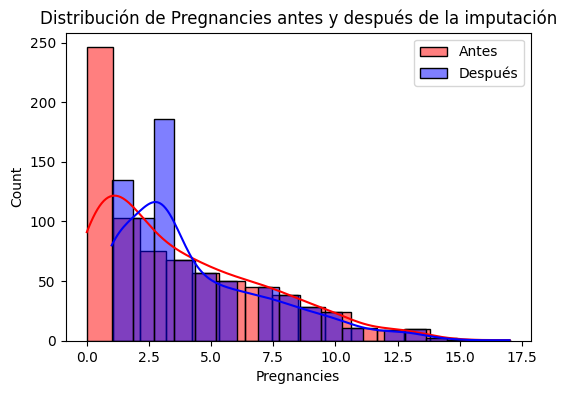

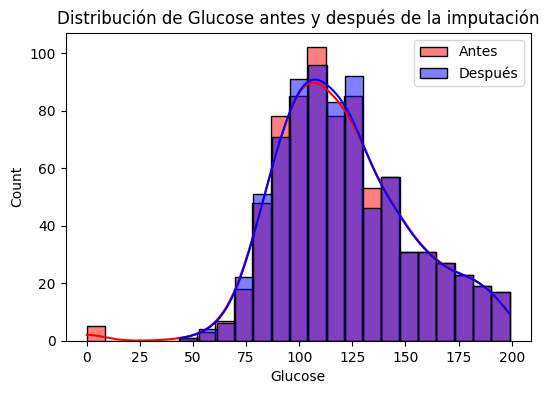

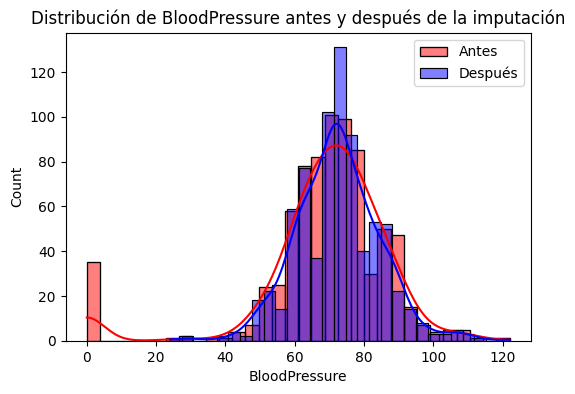

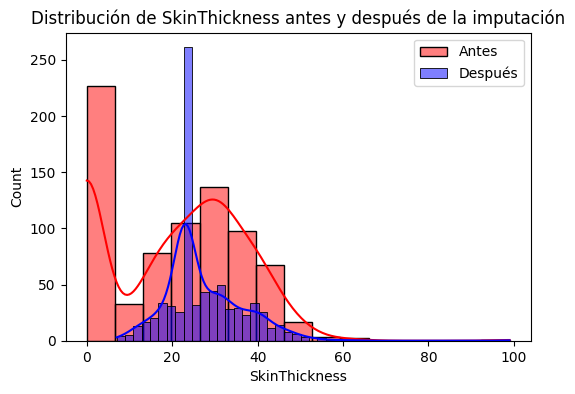

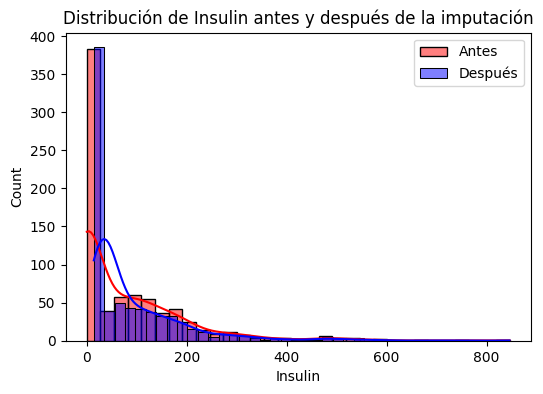

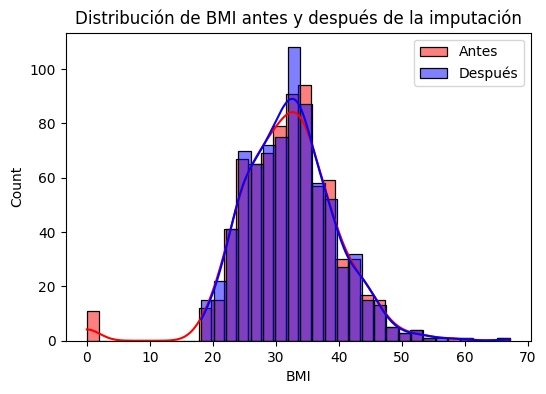

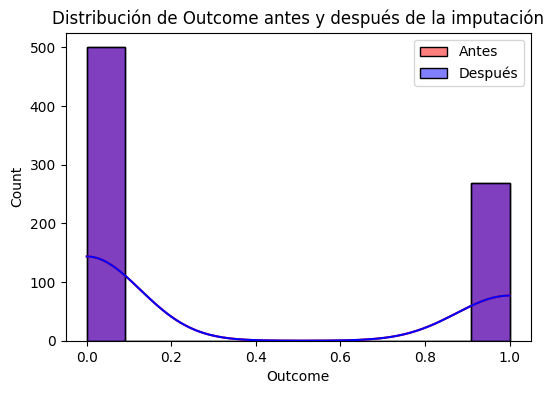

In [21]:
# Cambios en la distribución con histogramas
for col in zero_min_features:
    plt.figure(figsize=(6, 4))
    sns.histplot(df[col], bins="auto", kde=True, color="red", label="Antes")
    sns.histplot(df_imputed[col], bins="auto", kde=True, color="blue", label="Después")
    plt.title(f"Distribución de {col} antes y después de la imputación")
    plt.legend()
    plt.show()

In [15]:
# Preprocesar.
X = df_imputed.drop('Outcome', axis=1) # separamos variables predictoras.
y = df_imputed["Outcome"] # Guardamos la variable objetivo (diabetes: 0 = no, 1 = sí).
# Train y test.
# Dividimos los datos en entrenamiento (80%) y prueba (20%).
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
f"Train: {X_train.shape}, Test: {X_test.shape}"

'Train: (614, 8), Test: (154, 8)'

In [16]:
# Escalar datos
scaler = StandardScaler() # Normaliza las variables para mejorar el rendimiento del modelo.
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Entrenar Árbol de Decisión, definimos un árbol con una profundidad máxima de 4 niveles.
tree = DecisionTreeClassifier(max_depth = 4, random_state = 42)
tree.fit(X_train_scaled, y_train)

# Entrenamos el modelo con los datos normalizados.
y_pred = tree.predict(X_test_scaled)

# comprobaciones del modelo.
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}") # Precisión general del modelo
print(f"Precision: {precision_score(y_test, y_pred):.4f}") # Mide la proporción de positivos reales entre los predichos como positivos
print(f"Recall: {recall_score(y_test, y_pred):.4f}") # Evalúa qué porcentaje de casos positivos fueron correctamente identificados
print(f"F1 Score: {f1_score(y_test, y_pred):.4f}") # Combina precisión y recall para una evaluación equilibrada

Accuracy: 0.7078
Precision: 0.5676
Recall: 0.7636
F1 Score: 0.6512


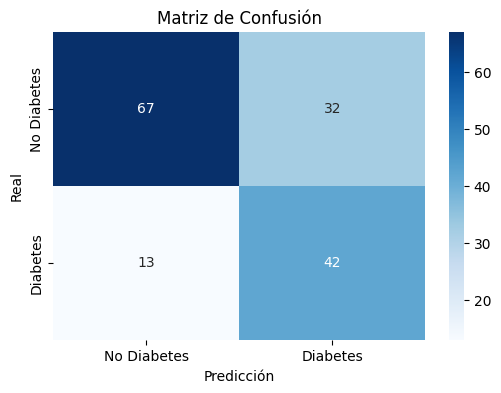

In [17]:
# Matriz de confusión
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Diabetes', 'Diabetes'], yticklabels=['No Diabetes', 'Diabetes'])
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión")
plt.show()

Verdaderos negativos (No Diabetes correctamente predicho): 67
Falsos positivos (Predicho como Diabetes, pero realmente No Diabetes): 32
Falsos negativos (Predicho como No Diabetes, pero realmente Diabetes): 13
Verdaderos positivos (Diabetes correctamente predicho): 42

In [18]:
# Optimización del modelo
param_grid = {
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 5, 10],
    'criterion': ['gini', 'entropy']
}
# Buscamos los mejores hiperparámetros probando diferentes combinaciones
grid_search = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_scaled, y_train) # Ejecuta la búsqueda sobre los datos de entrenamiento
print("Mejores parámetros:", grid_search.best_params_) # Muestra los mejores valores encontrados

Mejores parámetros: {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 10, 'min_samples_split': 2}


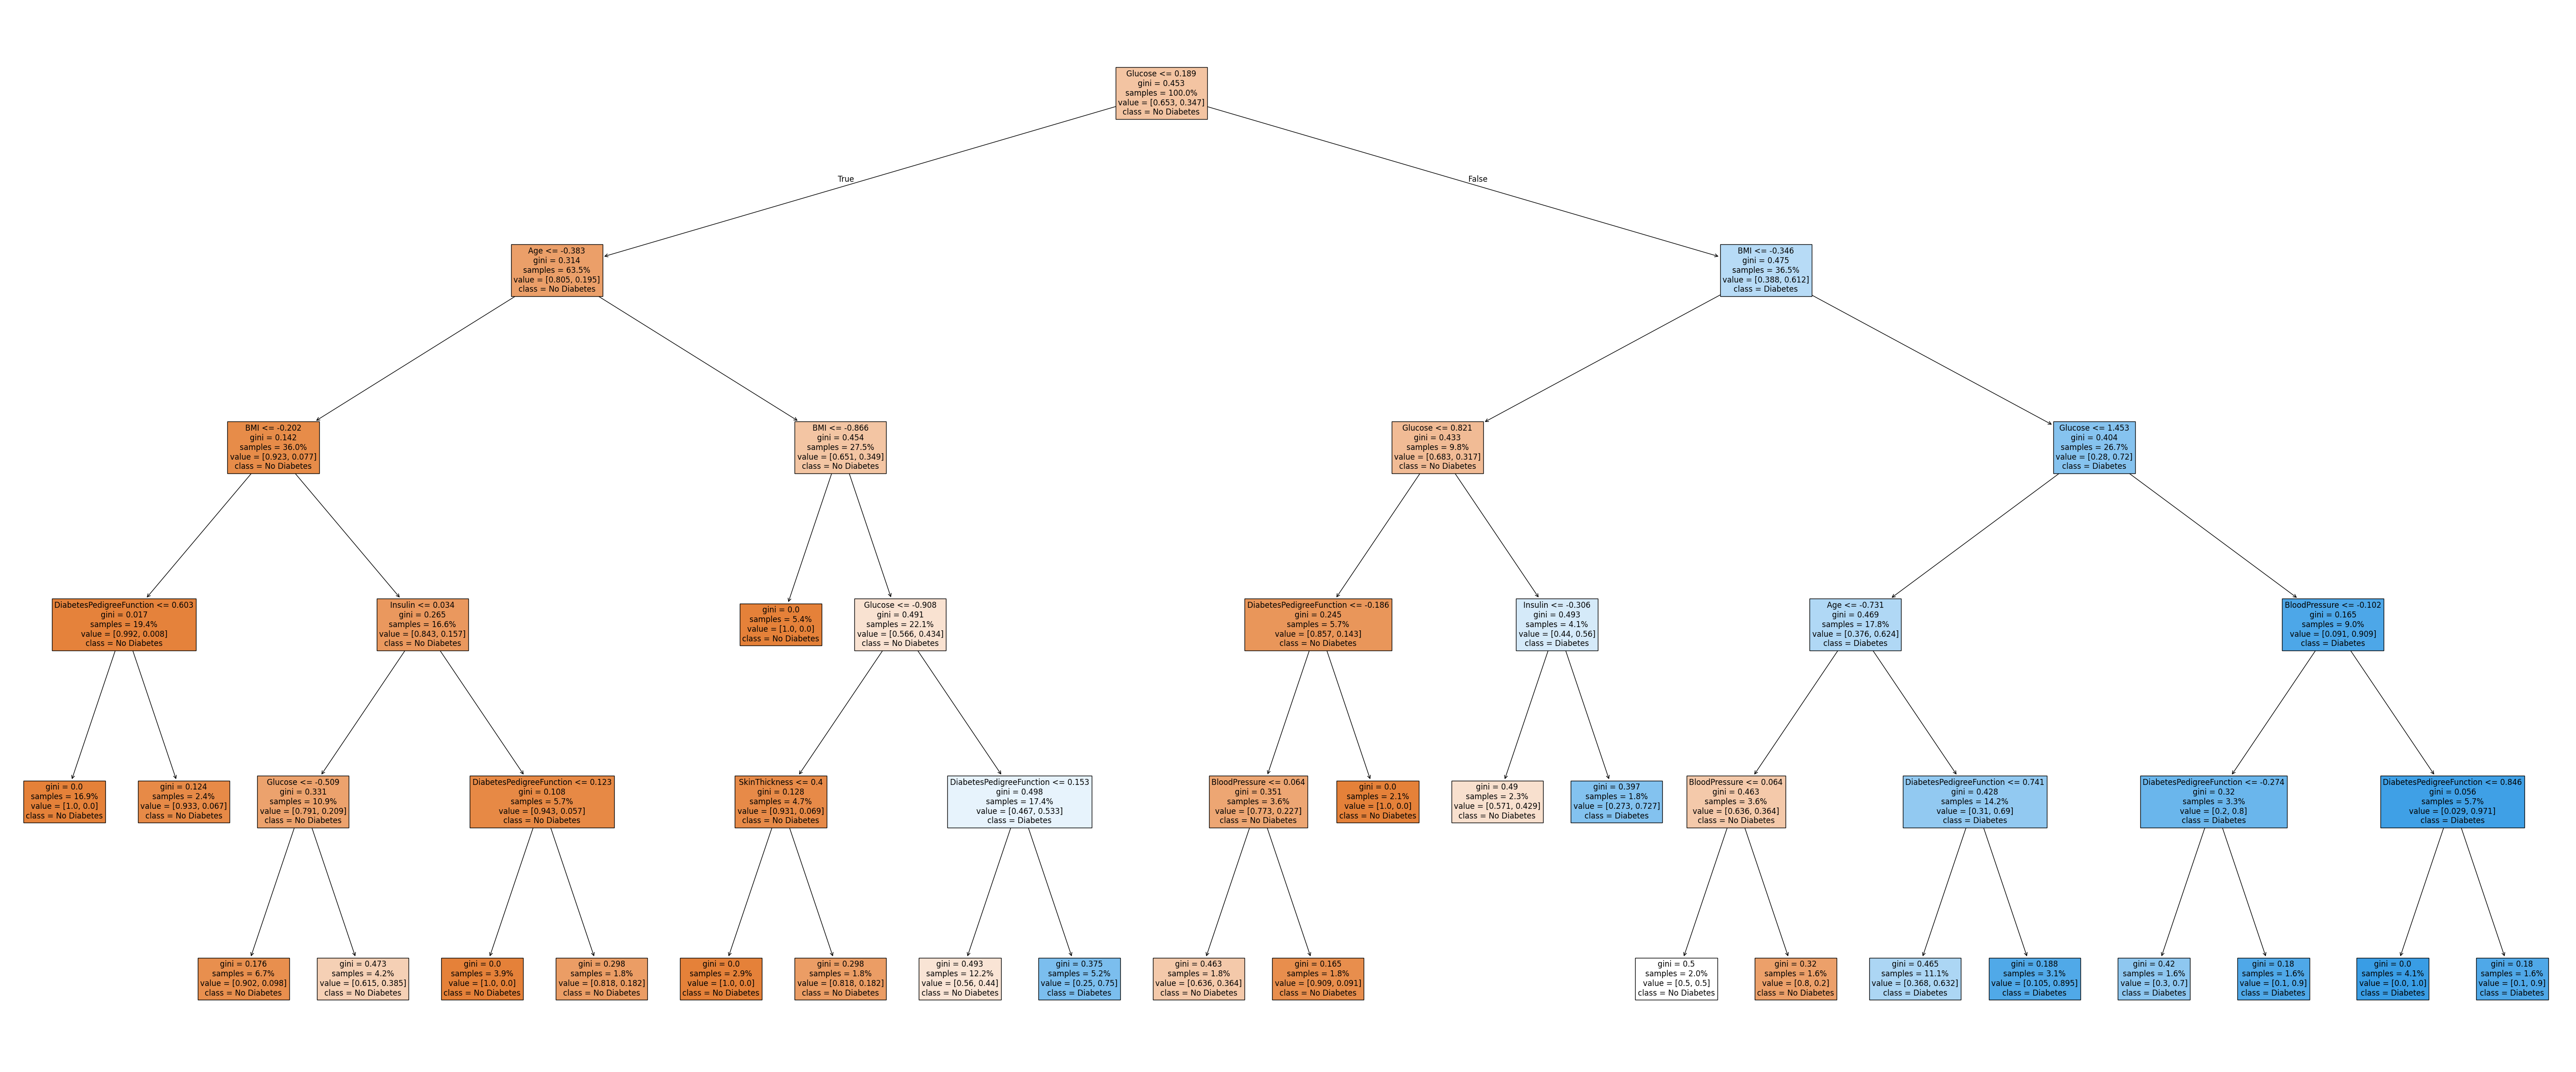

In [19]:
# Árbol final
final_tree = grid_search.best_estimator_
plt.figure(figsize=(72, 30))
plot_tree(final_tree, feature_names=X.columns, class_names=['No Diabetes', 'Diabetes'], filled=True, fontsize=12, proportion=True)
plt.show()

Se separa por color de quien tiene o no diabetes, aqui podriamos analizar las caracteristicas mas influyentes en las primeras divisiones del arbol, ajustar los hiperparametros, reduciendo max_depth o aumentando min_samples_split.